In [25]:
# Pandas
import geopandas as gp
import pandas as pd

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt

import datetime as dt

# Plotly libraries
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# IPYWidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import numpy as np
import math

# Statsmodels libraries
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
%matplotlib inline

init_notebook_mode(connected = True)

### Import dataset if csv exists

In [2]:
if os.path.exists('./city_temperature.csv'):
    df = pd.read_csv('./city_temperature.csv',low_memory=False)
    df['Date'] = pd.to_datetime(df.loc[:,'Month':'Year'],dayfirst=True,errors='coerce')

### Print dataset head

In [3]:
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Date
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2,1995-01-01
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4,1995-01-02
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8,1995-01-03
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4,1995-01-04
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9,1995-01-05


In [4]:
df.describe()

,Month,Day,Year,AvgTemperature
count,2.906327e+06,2.906327e+06,2.906327e+06,2.906327e+06
mean,6.469163e+00,1.571682e+01,2.006624e+03,5.600492e+01
std,3.456489e+00,8.800534e+00,2.338226e+01,3.212359e+01
min,1.000000e+00,0.000000e+00,2.000000e+02,-9.900000e+01
25%,3.000000e+00,8.000000e+00,2.001000e+03,4.580000e+01
50%,6.000000e+00,1.600000e+01,2.007000e+03,6.250000e+01
75%,9.000000e+00,2.300000e+01,2.013000e+03,7.550000e+01
max,1.200000e+01,3.100000e+01,2.020000e+03,1.100000e+02


In [5]:
print(f"Number of unique Countries: {len(df.Country.unique())}")
print(f"Number of unique Cities: {len(df.City.unique())} ")

Number of unique Countries: 125
Number of unique Cities: 321 


# US

## Group By Day

In [6]:
df_us = df[df['Country']=='US'].groupby([pd.Grouper(key='Date',freq='D')]).mean().unstack(level=0).reindex().AvgTemperature

## Remove and Interpolate Default Vals (-99 F)

In [7]:
df_us.where(df_us>-99,inplace=True)
df_us.interpolate(method='time',inplace=True)

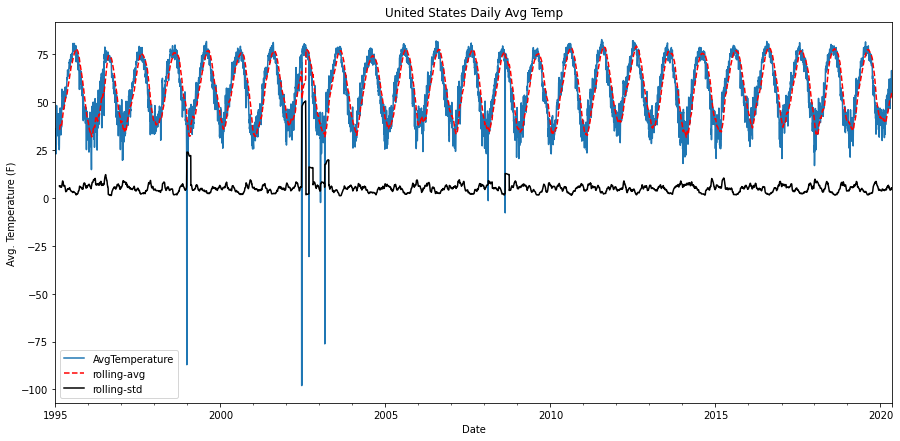

In [8]:
df_us.plot(title='United States Daily Avg Temp',figsize=(15,7),label='AvgTemperature')
df_us.rolling(window=45).mean().plot(color='r',linestyle='dashed',label='rolling-avg')
df_us.rolling(window=45).std().plot(color='black',label='rolling-std')
plt.ylabel('Avg. Temperature (F)')
plt.legend(loc='best')
plt.savefig('./Images/US/us_daily_avg_temp.jpeg')

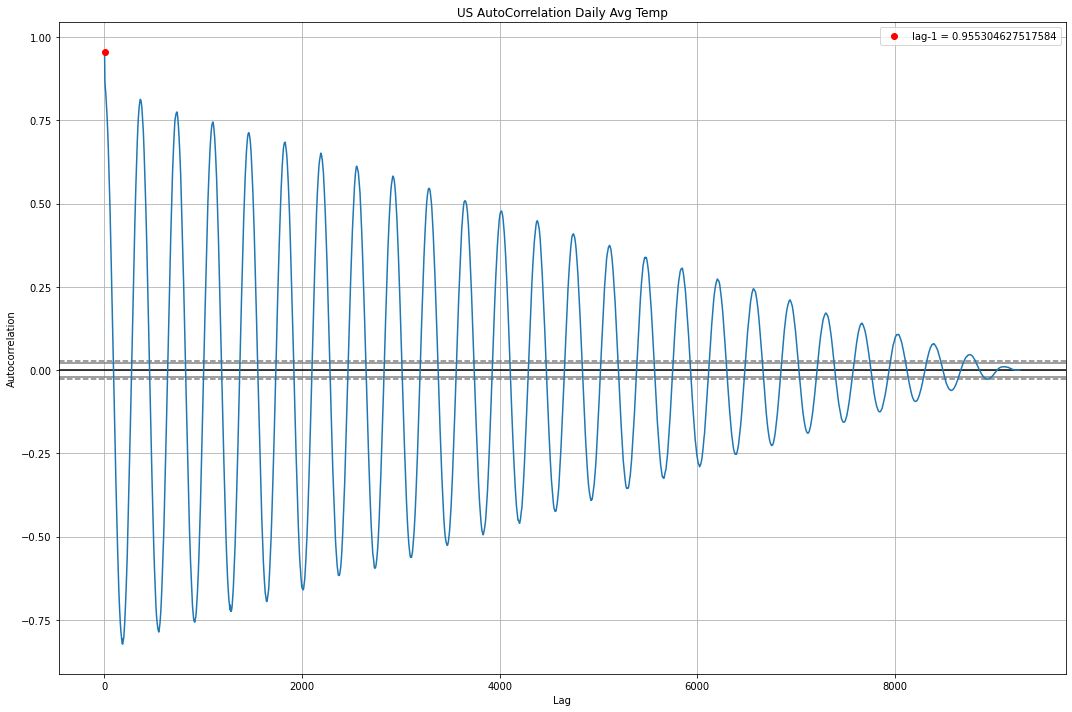

In [9]:
fig,ax=plt.subplots(figsize=(15,10))
pd.plotting.autocorrelation_plot(df_us,ax=ax)
plt.plot(1,df_us.autocorr(1),'ro',label=f'lag-1 = {df_us.autocorr(1)}')
plt.title('US AutoCorrelation Daily Avg Temp')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(f'./Images/US/us_autocorr_daily.jpeg')

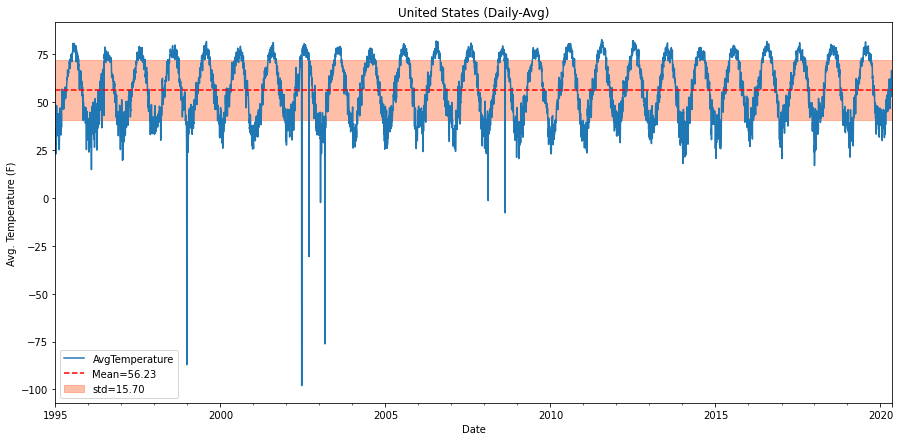

In [10]:
df_us.plot(title='United States (Daily-Avg)',figsize=(15,7),label='AvgTemperature')
plt.axhline(df_us.mean(),color='r',linestyle='dashed',label=f'Mean={df_us.mean():0.2f}')
plt.axhspan(df_us.mean()-df_us.std(),df_us.mean()+df_us.std(),alpha=0.5,color='coral',label=f'std={df_us.std():0.2f}')
plt.ylabel('Avg. Temperature (F)')
plt.legend()
plt.savefig('./Images/US/us_d_mean_std.jpeg')

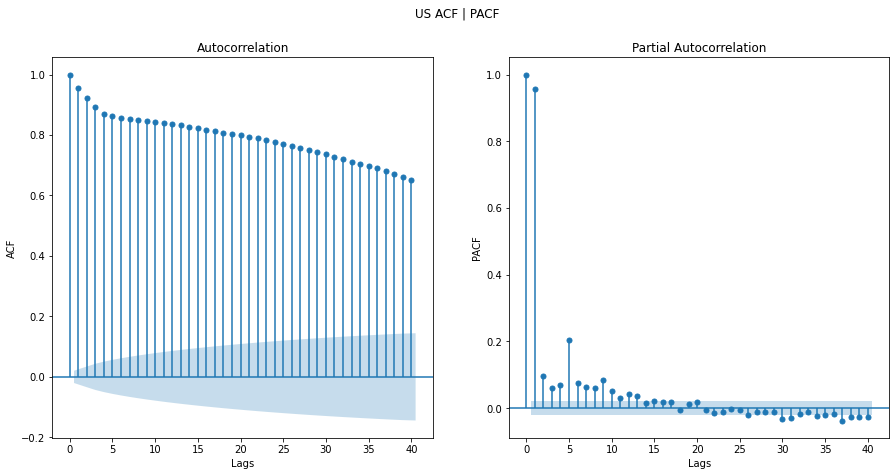

In [11]:
fig1,(ax1,ax2)=plt.subplots(1,2,figsize=(15,7))

# Plot ACF 
plot_acf(df_us.values.squeeze(),lags=40,ax=ax1)

plt.suptitle('US ACF | PACF')

ax1.set_xlabel('Lags')
ax1.set_ylabel('ACF')

# Plot PACF
plot_pacf(df_us,ax=ax2)

ax2.set_xlabel('Lags')
ax2.set_ylabel('PACF')

plt.savefig('./Images/US/acf_pacf_us.jpeg')

## Fit the model

### Train model on different parameters

In [12]:
mse = []
params = []
pvalues = []
for i in range(1,15):
    arm = ARIMA(df_us,order=(i,0,0)).fit()
    yhat = arm.predict()
    mse.append(np.linalg.norm(df_us-yhat)/df_us.size)

### Plot MSE vs. Parameter Values (all training data)

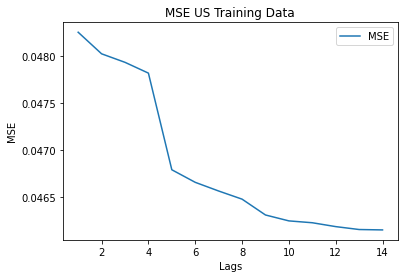

In [18]:
plt.plot(range(1,15),mse,label='MSE')
plt.ylabel('MSE')
plt.xlabel('Lags')
plt.title('MSE US Training Data')
plt.legend()
plt.savefig('./Images/US/us_mse_trainonly.jpeg')

In [42]:
num_folds=5
k_folds = np.split(df_us,num_folds)

# Index range for test/train folds
idx = np.arange(10)
end = 1
tot_err = []
for i in idx:
    test = k_folds[i+1] 
    train = pd.concat(k_folds[:i])
    model = logit('mature ~ Malat1 + Lars2', data=train).fit(disp=0)
    train_pred = model.predict()
    test_pred = model.forecast()
    
    train_err = sum(train_pred!=train.mature)/train.mature.size
    test_err = sum(test_pred!=test.mature)/test.mature.size
    tot_err.append([train_err,test_err])
    
tot_err = pd.DataFrame(tot_err,columns=['Train_Error','Test_Error'])
tot_err.head(10)
# for i in range(1,15):
#     arm = ARIMA(df_us,order=(i,0,0)).fit()
#     yhat = arm.predict()
#     mse.append(np.linalg.norm(df_us-yhat)/df_us.size)

pandas.core.series.Series

In [ ]:
y_hat = arm.predict()

In [ ]:
y_hat

In [ ]:
fig2,ax2=plt.subplots(figsize=(15,10))
plt.plot(y_hat,'r',axes=ax2,label='Predict')
plt.plot(df_us_m,'b',axes=ax2,label='Actual')
plt.legend()
plt.title('Actual vs. Predict (United States - Month)')

In [ ]:
np.linalg.norm(y_hat-df_us_m)/df_us_m.size

In [ ]:
df_us_d = df[df['Country']=='US'].groupby([pd.Grouper(key='Date',freq='D')]).mean().unstack(level=0).reindex().AvgTemperature
df_us_d.where(df_us_d>-99,inplace=True)

In [ ]:
df_us_d.interpolate(method='time',inplace=True)
df_us_d.plot(title='United States (1-Day)',figsize=(15,7),label='AvgTemperature')
plt.ylabel('Avg. Temperature (F)')
plt.legend()
plt.savefig('./Images/US/us_1d_plot.jpeg')

In [ ]:
fig,ax=plt.subplots(figsize=(15,10))
plot_acf(df_us_m,ax=ax)
plt.title('US AutoCorrelation')
plt.ylabel('ACF')
plt.savefig('./Images/US/acf_us.jpeg')

## PACF

In [ ]:
fig,ax=plt.subplots(figsize=(15,10))
plot_pacf(df_us_m,ax=ax)
plt.title('US AutoCorrelation')
plt.ylabel('PACF')
plt.savefig('./Images/US/pacf_us.jpeg')

In [ ]:
df_us_d.autocorr(lag=1)

In [ ]:
arm = ARIMA(df_us_m.iloc[1:-25],order=(7,0,1)).fit()

In [ ]:
arm.pvalues

In [ ]:
y_hat = arm.predict()
test = arm.get_prediction(start=-25).predicted_mean

In [ ]:
fig2,ax2=plt.subplots(figsize=(15,10))
plt.plot(y_hat,'r',axes=ax2,label='Predict')
plt.plot(test,'g',axes=ax2,label='Test')
plt.plot(df_us_m,'b',axes=ax2,label='Actual')
plt.legend()
plt.title('Actual vs. Predict (United States)')

In [ ]:
# np.linalg.norm(y_hat-df_us_m)/df_us_m.size
np.linalg.norm(test-df_us_m.iloc[-25:])#/len(df_us_m.iloc[-25:])

In [ ]:
arm.fittedvalues

In [ ]:
f = arm.forecast(25)

In [ ]:
f

In [ ]:
np.linalg.norm(f-df_us_m[-25:])/df_us_m.size

# Canada